# Initialization


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


Reading part (1/n) of the data

In [0]:
def skiprow(i, n):
    if i % n == 0:
       return False
    return True


Change n to load more, or less of the data.

In [3]:
n=5
train_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_train.csv.zip?raw=true'
test_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_test.csv.zip?raw=true'
train = pd.read_csv(train_url, compression='zip', skiprows = lambda x: skiprow(x, n))
test = pd.read_csv(test_url, compression='zip' , skiprows = lambda x: skiprow(x, 1))

train.shape

(12000, 785)

In [4]:
train.sample(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
10795,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8800,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9617,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8293,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df=train.drop('label', axis = 1)
df.sample(5)

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

In [0]:
y=train.label
X=train.drop('label', axis=1)
X_test = test.drop('label', axis=1)


# Define models

Multi label models.

In [0]:
models = []
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('Linear SVM', SVC(gamma='scale', C=1, decision_function_shape='ovo', verbose=True)))
models.append(('Neural Net', MLPClassifier(alpha=0.0001, solver='sgd', verbose=True)))
models.append(('XGB', XGBClassifier(verbosity=2, objective='multi:softmax', num_class=10)))
models.append(('LR', LogisticRegression(solver="saga", multi_class="multinomial", max_iter=1000, verbose=2))) # ovr - one versus reset
models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, verbose=2)))


# Model fitting and prediction

In [0]:
def model_score(name, model, X, y, val_y, y_pred, y_test, icv):
    #print('Running CV score')
    cvscore = cross_val_score(model, X, y, cv=icv)
    print('Model {0} score: {1:.4f} and std dev: {2:.4f}'.format(name, cvscore.mean(), cvscore.std()))
    print('Validation variance score: %.4f' % r2_score(val_y, y_pred))
    print('Test variance score: %.4f' % r2_score(test.label, y_test))

    return cvscore, r2_score(val_y, y_pred), r2_score(test.label, y_test)

In [0]:
def cv_fit_and_predict(models, X, y):
    results = []
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    for name, model in models:
        #print("Fitting model {}".format(name))
        m = model.fit(train_X, train_y)
        #print("Fitted model is {}".format(m))
        #print('Running prediction')
        y_pred = model.predict(val_X)
        y_test = model.predict(X_test)
        score, val_r2, test_r2 = model_score(name, model, X, y, val_y, y_pred, y_test, 10)
        results.append((name, score, val_r2, test_r2))
    print("Done")
    return results


In [10]:
results = cv_fit_and_predict(models, X, y)

Model KNN score: 0.9441 and std dev: 0.0083
Validation variance score: 0.8512
Test variance score: 0.8851
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Model Linear SVM score: 0.9588 and std dev: 0.0059
Validation variance score: 0.8990
Test variance score: 0.9150
Iteration 1, loss = 3.91112246
Iteration 2, loss = 1.67939927
Iteration 3, loss = 1.57028599
Iteration 4, loss = 1.49816392
Iteration 5, loss = 1.42333745
Iteration 6, loss = 1.31552102
Iteration 7, loss = 1.23247402
Iteration 8, loss = 1.17491344
Iteration 9, loss = 1.08049027
Iteration 10, loss = 1.01417861
Iteration 11, loss = 1.02138177
Iteration 12, loss = 0.96542855
Iteration 13, loss = 0.93406935
Iteration 14, loss = 0.93911399
Iteration 15, loss = 0.89218608
Iteration 16, loss = 0.84963829
Iteration 17, loss = 0.82408945
Iteration 18, loss = 0.80728782
Iteration 19, loss = 0.76045112
Iteration 20, loss = 0.75054814
Iteration 21, loss = 0.71704364
Iteration 22, loss = 0.6944537

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.51180918
Iteration 2, loss = 1.44530864
Iteration 3, loss = 1.16270343
Iteration 4, loss = 1.04757208
Iteration 5, loss = 0.93894623
Iteration 6, loss = 0.87305515
Iteration 7, loss = 0.81354910
Iteration 8, loss = 0.76717038
Iteration 9, loss = 0.69548090
Iteration 10, loss = 0.64070735
Iteration 11, loss = 0.61200155
Iteration 12, loss = 0.58691702
Iteration 13, loss = 0.56926865
Iteration 14, loss = 0.56218429
Iteration 15, loss = 0.54164667
Iteration 16, loss = 0.51804031
Iteration 17, loss = 0.53206126
Iteration 18, loss = 0.49727502
Iteration 19, loss = 0.47937919
Iteration 20, loss = 0.47159766
Iteration 21, loss = 0.46802905
Iteration 22, loss = 0.44976282
Iteration 23, loss = 0.42949420
Iteration 24, loss = 0.42609046
Iteration 25, loss = 0.42290442
Iteration 26, loss = 0.41082415
Iteration 27, loss = 0.40453186
Iteration 28, loss = 0.39740299
Iteration 29, loss = 0.39378269
Iteration 30, loss = 0.38652492
Iteration 31, loss = 0.37800965
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.52383630
Iteration 2, loss = 1.55754605
Iteration 3, loss = 1.32164956
Iteration 4, loss = 1.19490324
Iteration 5, loss = 1.06590965
Iteration 6, loss = 0.94531834
Iteration 7, loss = 0.89967101
Iteration 8, loss = 0.79628305
Iteration 9, loss = 0.73599057
Iteration 10, loss = 0.72151953
Iteration 11, loss = 0.66884856
Iteration 12, loss = 0.61309090
Iteration 13, loss = 0.56298360
Iteration 14, loss = 0.53363632
Iteration 15, loss = 0.52126916
Iteration 16, loss = 0.48496822
Iteration 17, loss = 0.45416203
Iteration 18, loss = 0.43277741
Iteration 19, loss = 0.41822342
Iteration 20, loss = 0.39983471
Iteration 21, loss = 0.38402234
Iteration 22, loss = 0.37189193
Iteration 23, loss = 0.36082464
Iteration 24, loss = 0.35455858
Iteration 25, loss = 0.34954012
Iteration 26, loss = 0.34209095
Iteration 27, loss = 0.33113990
Iteration 28, loss = 0.32850039
Iteration 29, loss = 0.33625692
Iteration 30, loss = 0.31603686
Iteration 31, loss = 0.31259436
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.76850390
Iteration 2, loss = 1.77761050
Iteration 3, loss = 1.46429772
Iteration 4, loss = 1.19714098
Iteration 5, loss = 1.04432795
Iteration 6, loss = 0.95297217
Iteration 7, loss = 0.85168550
Iteration 8, loss = 0.77347050
Iteration 9, loss = 0.69112123
Iteration 10, loss = 0.62778917
Iteration 11, loss = 0.58938852
Iteration 12, loss = 0.55444135
Iteration 13, loss = 0.51828525
Iteration 14, loss = 0.49010620
Iteration 15, loss = 0.47205254
Iteration 16, loss = 0.45642178
Iteration 17, loss = 0.44099982
Iteration 18, loss = 0.42423941
Iteration 19, loss = 0.42405431
Iteration 20, loss = 0.40587483
Iteration 21, loss = 0.40891605
Iteration 22, loss = 0.39811832
Iteration 23, loss = 0.37900767
Iteration 24, loss = 0.38018288
Iteration 25, loss = 0.37009048
Iteration 26, loss = 0.37104583
Iteration 27, loss = 0.35467349
Iteration 28, loss = 0.35328111
Iteration 29, loss = 0.34977415
Iteration 30, loss = 0.33673768
Iteration 31, loss = 0.33549797
Iteration 32, los

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 408 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 487 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 488 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 489 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 489 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 489 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 489 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 490 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 491 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 490 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 491 seconds
Model LR score: 0.8699 and std dev: 0.0113
Validation variance score: 0.7383
Test variance score: 0.7747
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)

building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
buildi

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Paral

building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Paral

building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Model RF score: 0.6305 and std dev: 0.0241
Validation variance score: 0.0167
Test variance score: 0.0761
Done


# Validation and results

In [0]:
def model_validation(results):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model CV score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,2])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Models variance score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,3])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Test variance score')
    plt.show()
    
    return 0

In [0]:
np_results=np.array(results, object)

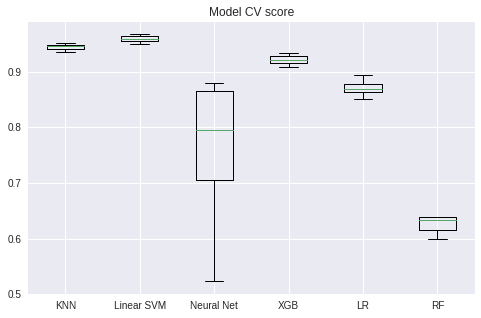

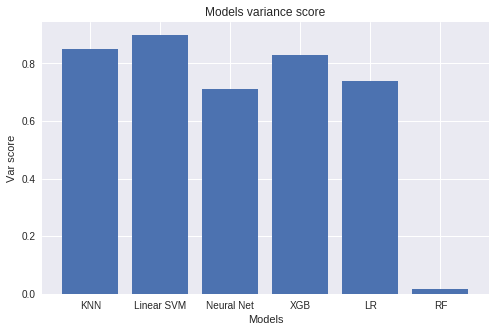

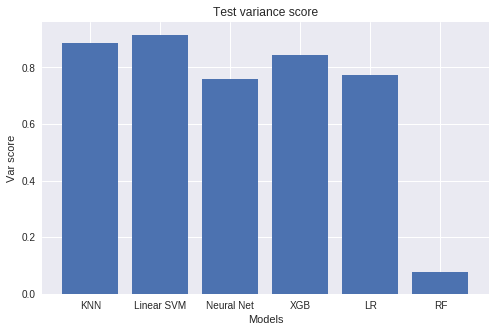

In [22]:
status = model_validation(np_results)

fi = imodel.fit(X, y).feature_importances_
pos = np.arange(len(X.columns))
print("Best performing model", imodel)
plt.figure(figsize=(13, 8))
plt.barh(pos, fi)
plt.title("Feature Importance")
plt.xlabel("Model Accuracy")
plt.ylabel("Features")
plt.yticks(pos, (list(X)))
plt.show()

preds = imodel.predict(X_test)
print('Variance score: %.4f' % r2_score(test.label, preds))

pd.DataFrame({"ImageId": list(range(1,len(preds)+1)), "Label": preds, "test_label":test.label})
